# Notebook 1: Reproduce RGCN Model with APIs (v0.1 and not runnable)

This notebook is the first in a series that demonstrates how to use GraphStorm's APIs to create users' own graph machine learning setup by leveraging GraphStorm's easy-to-use and great scalability features. All of these notebooks are designed to run on GraphStorm's Standalone mode, i.e., in a single Linux machine with CPUs and GPUs. 

In this notebook, we willl reproduce the GraphStorm RGCN model with the nessessary APIs and use it to conduct a node classification task on the ACM dataset. By playing with this notebook, users will be able to get familiar with these APIs.

### Prerequsites

- GraphStorm installed using pip. Please find [more details on installation of GraphStorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).
- ACM data created in the [Notebook 0: Data Prepare](https://graphstorm.readthedocs.io/en/latest/notebooks/Notebook_0_Data_Prepare.html), and is stored in the `./acm_gs_1p/` folder.
- Installation of supporting libraries, e.g., matplotlib.

In [1]:
import graphstorm as gs

---

### 0. Initialize the GraphStorm Standalone Environment

We might set default argument values in `gs.initialize()` for the Standalone mode.

In [2]:
gs.initialize()

### 1. Setup GraphStorm Dataset and DataLoaders

The role of `gs.dataset.GSgnnData` is mainly for loading and storing given partitioned graphs. The existing roles such as target node type, label field, and node feature for training/inference, will move to Dataloader classes. 

In [4]:
# create a GraphStorm Dataset for the ACM graph data 
acm_data = gs.dataset.GSgnnData(part_config='./acm_gs_1p/acm.json')

`Dataloaders` take node feature dictionary and label field string. They do not handle features and labels, but pass these information to `Datasets`. And then `Datasets` retrieve related information and return to `Dataloaders`.

In [5]:
# define dataloaders for training and validation
train_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_train_set(ntypes=['paper']),
    node_feats={'author':['feat'], 'paper':['feat'],'subject':['feat']},
    label_field='label',
    fanout=[20, 20],
    batch_size=64,
    train_task=True)
val_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_val_set(ntypes=['paper']),
    node_feats={'author':['feat'], 'paper':['feat'],'subject':['feat']},
    label_field='label',
    fanout=[100, 100],
    batch_size=256,
    train_task=False)

### 2. Create a GraphStorm-compatible RGCN Model for Node Classification 

This `Model` could be a customized model extends from `GSgnnModel` and implements required methods. The `GSgnnModel` has a few new API features.

1. It asks for graph metadata, instead of the DistGraph.
2. It will run `model.init_optimizer()` by default.

In [6]:
# import a customized RGCN model for node classification
from model import RgcnNCModel
model = RgcnNCModel(
    graph_metadata=acm_data.get_graph_metadata,
    hid_size=128,
    num_hidden_layers=2,
    num_classes=14)

### 3. Setup a GraphStorm Evaluator

Now, `Evaluators` are task-oriented, i.e., `ClassificationEvaluator`, `RegressionEvaluator`, and `LPEvaluator`. And each Evaluator constructor could have a default evaluation metrics, i.e., `accuracy` for classification, `mse` for regression, and `mrr` for link prediction.

In [7]:
# setup a Classification evaluator for the trainer
evaluator = gs.eval.GSgnnClassificationEvaluator(eval_frequency=100)

### 4. Setup a Trainer and Training

In [8]:
# create a GraphStorm node task trainer for the RGCN model
trainer = gs.trainer.GSgnnNodeTrainer(model, evaluator)

# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            num_epochs=10,
            save_model_path='a_save_path/')

### (Optional) 5. Visualize Model Performance History

Next, we examine the model performance on the validation, and testing over the training process.

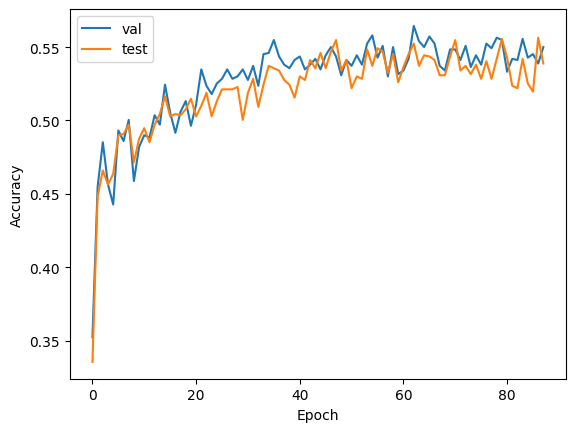

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the trainer's evaluator:
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['accuracy'])
    test_metrics.append(test_metric['accuracy'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val')
ax.plot(test_metrics, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best')

### 6. Inference with the Trained Model

GraphStorm automatically save the best performaned model in the given `save_model_path` argument. We can first find out what is the best model and its path.

In [10]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

In [11]:
# we can restore the model from the saved path using the model's restore_model() function.
model.restore_model(best_model_path)

In [12]:
# Setup dataloader for inference
infer_dataloader = GSgnnNodeDataLoader(dataset=acm_data,
                                       target_idx=acm_data.test_idxs,
                                       fanout=[50,50],
                                       batch_size=100,
                                       device=device,
                                       train_task=False)
# Create an Inferrer object
infer = GSgnnNodePredictionInferrer(model)

In [13]:
# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

In [14]:
# The GNN embeddings and predictions on the inference graph are saved to the folder named after the target_ntype
!ls -lh infer/embeddings/paper
!ls -lh infer/predictions/paper

total 640K
-rw-rw-r-- 1 ubuntu ubuntu 626K Jan 26 20:54 embed-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu  11K Jan 26 20:54 embed_nids-00000.pt
total 84K
-rw-rw-r-- 1 ubuntu ubuntu 70K Jan 26 20:54 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 11K Jan 26 20:54 predict_nids-00000.pt
